# Celebrity Face Recognition System

## Overview
This project implements a deep learning-based celebrity face recognition system using VGG-Face embeddings and a custom CNN classifier. The system can detect faces in images, recognize celebrities, and handle unknown faces with confidence thresholding.

## Features
- Face detection and alignment using DeepFace
- Transfer learning using VGG-Face embeddings
- Custom CNN classifier for celebrity recognition
- Confidence thresholding for unknown face detection
- Visualization tools for results
- Training history visualization
- Early stopping to prevent overfitting

## Dependencies
```bash
tensorflow
opencv-python
deepface
numpy
matplotlib
scikit-learn
```

## Project Structure
```
.
├── datasets/
│   └── stars/
│       ├── celebrity1/
│       ├── celebrity2/
│       └── ...
├── models/
│   └── face_classifier.h5
└── main.py
```

## Installation
1. Clone the repository
2. Install required packages:
```bash
pip install tensorflow opencv-python deepface numpy matplotlib scikit-learn
```

## Dataset Preparation
Place your celebrity images in the following structure:
```
datasets/stars/
    ├── celebrity_name1/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    ├── celebrity_name2/
    │   ├── image1.jpg
    │   └── ...
    └── ...
```


### Import Libraries

In [64]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from deepface import DeepFace
from deepface.commons.logger import Logger
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### 1. Model Initialization

In [65]:
# initialise VGG-Face model
model = DeepFace.build_model("VGG-Face")
# target size
target_size = model.input_shape
target_size

(224, 224)

In [66]:
# initialise label encoder
le = LabelEncoder()

### 2. Face Embedding Extraction

In [67]:
# load dataset
def get_face_embedding( img_path):
    """Extract face embedding from an image"""
    try:
        face = DeepFace.extract_faces(img_path=img_path)[0]["face"]
        face = cv2.resize(face, target_size)
        face = np.expand_dims(face, axis=0)
        embedding = model.forward(face)
        return embedding
    except Exception as e:
        print(f"Error extracting embedding from {img_path}: {str(e)}")
        return None


### Load Data

In [68]:

def load_dataset():
    """Load dataset and prepare embeddings and labels"""
    
    embeddings_train = []
    labels_train = []
    dataset_path = "datasets/stars"
    
    for celebrity_name in os.listdir(dataset_path):
        celebrity_path = os.path.join(dataset_path, celebrity_name)
        if os.path.isdir(celebrity_path):
            celebrity_images = 0
            for img_file in os.listdir(celebrity_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(celebrity_path, img_file)
                    embedding = get_face_embedding(img_path)
                    
                    if embedding is not None:
                        print(f"Embedding shape: {np.array(embedding).shape}")
                        print(f"Celebrity: {celebrity_name}")   
                        embeddings_train.append(embedding)
                        labels_train.append(celebrity_name)
                        celebrity_images += 1
            
            print(f"Loaded {celebrity_images} images for {celebrity_name}")
    return np.array(embeddings_train), np.array(labels_train)
        

In [69]:
embeddings, labels = load_dataset()

Embedding shape: (4096,)
Celebrity: prithviraj
Embedding shape: (4096,)
Celebrity: prithviraj
Embedding shape: (4096,)
Celebrity: prithviraj
Embedding shape: (4096,)
Celebrity: prithviraj
Loaded 4 images for prithviraj
Embedding shape: (4096,)
Celebrity: mohanlal
Embedding shape: (4096,)
Celebrity: mohanlal
Embedding shape: (4096,)
Celebrity: mohanlal
Embedding shape: (4096,)
Celebrity: mohanlal
Loaded 4 images for mohanlal
Embedding shape: (4096,)
Celebrity: mammootty
Embedding shape: (4096,)
Celebrity: mammootty
Embedding shape: (4096,)
Celebrity: mammootty
Embedding shape: (4096,)
Celebrity: mammootty
Loaded 4 images for mammootty
Error extracting embedding from datasets/stars/dq/channels4_profile.jpg: Face could not be detected in datasets/stars/dq/channels4_profile.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Error extracting embedding from datasets/stars/dq/channels4_profile copy.jpg: Face could not be detected in datase

In [70]:
embeddings[0].shape

(4096,)

In [71]:
X_train, X_val, y_train, y_val = train_test_split(
    embeddings, 
    labels,
    test_size=0.3,
    stratify=labels,
    random_state=42
)
        

In [72]:
X_train.shape, X_val.shape

((9, 4096), (5, 4096))

In [73]:
embedding_size = embeddings[0].shape[0]
embedding_size

4096

In [74]:
# number of classes
num_classes = len(np.unique(labels))

### 3. Custom CNN Classifier Architecture

In [75]:

# two layer 1D CNN model with adjusted kernel size
classifier = models.Sequential([
    layers.Input(shape=(embedding_size, 1)),
    layers.Conv1D(64, 1, activation='relu'),  # Adjusted kernel size to 1
    layers.MaxPooling1D(1),
    layers.Conv1D(32, 1, activation='relu'),  # Adjusted kernel size to 1
    layers.MaxPooling1D(1),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

In [76]:
# Compile model
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [77]:
# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Print model summary
classifier.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 4096, 64)          128       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 4096, 64)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 4096, 32)          2080      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 4096, 32)         0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 4)                

In [78]:
def plot_training_history(history):
    """Plot training and validation accuracy/loss"""
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### 4. Training the Model

Epoch 1/50
1/1 [==============================] - 0s 285ms/step - loss: 1.3864 - accuracy: 0.1111 - val_loss: 1.3708 - val_accuracy: 0.8000
Epoch 2/50
1/1 [==============================] - 0s 30ms/step - loss: 1.3656 - accuracy: 1.0000 - val_loss: 1.3652 - val_accuracy: 0.4000
Epoch 3/50
1/1 [==============================] - 0s 29ms/step - loss: 1.3233 - accuracy: 0.6667 - val_loss: 1.3890 - val_accuracy: 0.4000
Epoch 4/50
1/1 [==============================] - 0s 37ms/step - loss: 1.2673 - accuracy: 0.6667 - val_loss: 1.4671 - val_accuracy: 0.4000
Epoch 5/50
1/1 [==============================] - 0s 31ms/step - loss: 1.2263 - accuracy: 0.6667 - val_loss: 1.5081 - val_accuracy: 0.4000
Epoch 6/50
1/1 [==============================] - 0s 32ms/step - loss: 1.2051 - accuracy: 0.6667 - val_loss: 1.4215 - val_accuracy: 0.4000
Epoch 7/50
1/1 [==============================] - 0s 31ms/step - loss: 1.1667 - accuracy: 0.6667 - val_loss: 1.3204 - val_accuracy: 0.8000
Epoch 8/50
1/1 [==========

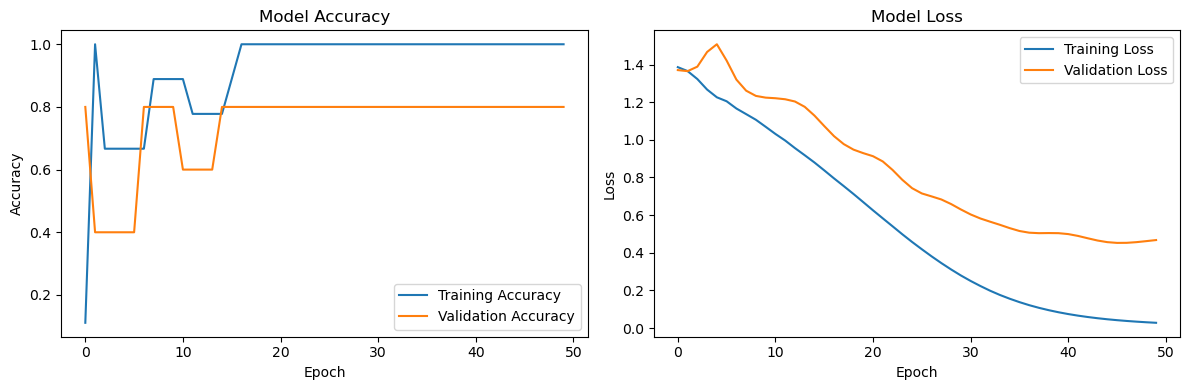

In [79]:
# Encode labels
le.fit(y_train)
y_train_encoded = le.transform(y_train)
y_val_encoded = le.transform(y_val)

# Train the model with encoded labels
history = classifier.fit(
    X_train, y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

plot_training_history(history)

In [80]:
# save model
classifier.save("models/face_classifier.h5")

In [81]:
# give the path of the image to be predicted
img_path = "datasets/stars/mohanlal/1.jpg"
embedding = get_face_embedding(img_path)
embedding = np.expand_dims(embedding, axis=-1)
embedding.shape

(4096, 1)

### Prediction

In [82]:
def visualize_result(test_img_path, result, confidence, face_coords):
    """Visualize the recognition result with bounding box"""
    # Load and display test image
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    
    # Create figure and axis
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(test_img)
    
    # Create a Rectangle patch for the face
    rect = patches.Rectangle(
        (face_coords['x'], face_coords['y']),
        face_coords['w'],
        face_coords['h'],
        linewidth=2,
        edgecolor='g' if result != "Unknown Person" else 'r',
        facecolor='none'
    )
    
    # Add the rectangle to the plot
    ax.add_patch(rect)
    
    # Add text above bounding box
    plt.text(
        face_coords['x'], 
        face_coords['y'] - 10, 
        f"{result} ({confidence:.2%})",
        color='white',
        fontsize=12,
        bbox=dict(facecolor='g' if result != "Unknown Person" else 'r', alpha=0.8)
    )
    
    plt.title("Celebrity Recognition Result")
    plt.axis('off')
    plt.show()

In [83]:
def identify_celebrity(test_img_path, visualize=True):
    """Identify the celebrity in a test image using CNN classifier"""
    # try:
    # Get test image embedding and face coordinates
    test_embedding, face_coords = detect_face(test_img_path)
    # print(test_embedding, face_coords)
    
    if test_embedding is None:
        return "No face detected", 0.0, None
    
    print(len(test_embedding))
    # Get prediction probabilities from CNN
    pred_probs = classifier.predict(np.array(test_embedding).reshape(1,-1,1), verbose=0)
    print(pred_probs)
    pred_class = np.argmax(pred_probs[0])
    print(pred_class)
    confidence = pred_probs[0][pred_class]
    
    # Get predicted celebrity name
    predicted_celebrity = le.inverse_transform([pred_class])[0]
    
    # Use confidence threshold
    if confidence < 0.7:  # Adjustable threshold
        result = "Unknown Person"
        confidence = 1 - confidence  # Confidence of being unknown
    else:
        result = predicted_celebrity

    if visualize:
        visualize_result(test_img_path, result, confidence, face_coords)

    return result, confidence, face_coords

    # except Exception as e:
    #     print(f"Error processing test image: {str(e)}")
    #     return "Error", None, None
        
def detect_face(img_path):
    """Detect face and return both the face embedding and detection details"""
    try:
        detection = DeepFace.extract_faces(
            img_path=img_path, 
            enforce_detection=True, 
            align=True,
            detector_backend='opencv'
        )[0]
        
        face = detection["face"]
        face_coords = {
            'x': detection['facial_area']['x'],
            'y': detection['facial_area']['y'],
            'w': detection['facial_area']['w'],
            'h': detection['facial_area']['h']
        }
        
        face = cv2.resize(face, target_size)
        face = np.expand_dims(face, axis=0)
        embedding = get_face_embedding(img_path) #model.predict(face)
        
        return embedding, face_coords
    except Exception as e:
        print(f"Error detecting face: {str(e)}")
        return None, None

4096
[[0.00283464 0.03497427 0.00913795 0.9530532 ]]
3


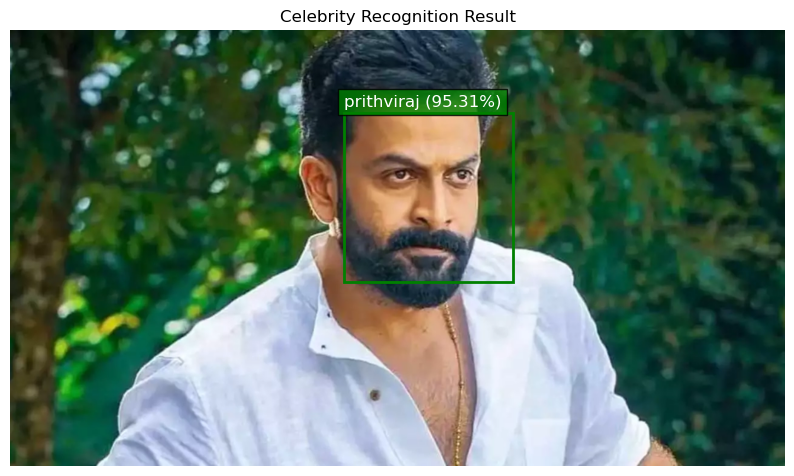

Identified Celebrity: prithviraj
Confidence: 0.9530531764030457


In [84]:
# Test with a new image
test_image_path = "datasets/stars/prithviraj/1.jpg"

# For single face detection
celebrity, confidence, face_coords = identify_celebrity(test_image_path)
print(f"Identified Celebrity: {celebrity}")
print(f"Confidence: {confidence}")
    